<a id=top-page></a>

<h1>
<center>
→ Physical insight into the optimized PVs
</center>
</h1>

<h3>
<center>
📄 Optimizing progress variables for ammonia/hydrogen combustion using encoding-decoding networks
</center>
</h3>

<center>
K. Zdybał, J. C. Sutherland, A. Parente, Combustion and Flame (2024)
</center>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#5perc">Violin plot for 5% dilution</a></li>
    <li><a href="#10perc">Violin plot for 10% dilution</a></li>
    <li><a href="#25perc">Violin plot for 25% dilution</a></li>
    <li><a href="#40perc">Violin plot for 40% dilution</a></li>
</ol>
<p></p>
</div>
<br>

***

#### The user should only modify the `pure_streams` parameter below. Set to `False` to view results corresponding to non-trainable pure stream components (NH$_3$, H$_2$, and O$_2$ are excluded from PV definition). Otherwise set to `True`.

In [1]:
pure_streams = True

***

In [2]:
%run -i imports.py
%matplotlib inline

Python==3.10.13

numpy==1.26.2
pandas==2.1.3
scipy==1.11.4
scikit-learn==1.3.2
PCAfold==2.2.0


In [3]:
data_type = 'SLF'
target_variables_indices = [0, 1, 3, 5, 6, 9]

In [4]:
if pure_streams:
    main_pathway_idx = [8, 9, 11, 15, 21, 23, 24, 25]
else:
    main_pathway_idx = [6, 7, 9, 13, 18, 20, 21, 22]

In [5]:
def populate_weights_matrix(model_weights_filename, random_seeds_list):

    weights_collected = np.zeros((len(random_seeds_list), n_variables-1))

    for i, random_seed in enumerate(random_seeds_list):

        hf = h5py.File(model_weights_filename + str(random_seed) + '.h5', 'r')
        current_weights = np.array(hf.get('0'))
        hf.close()
    
        current_weights = np.abs(current_weights) / np.max(np.abs((current_weights)))
    
        weights_collected[i,:] = current_weights.ravel()

    return weights_collected

In [6]:
def populate_max_matrix(model_weights_filename, random_seeds_list):

    max_collected = np.zeros((len(random_seeds_list), n_variables-1))

    for i, random_seed in enumerate(random_seeds_list):

        hf = h5py.File(model_weights_filename + str(random_seed) + '.h5', 'r')
        current_weights = np.array(hf.get('0'))
        hf.close()

        scaled_state_space = state_space[:,1::] * np.abs(current_weights.ravel())

        current_max = np.max(scaled_state_space, axis=0)

        max_collected[i,:] = current_max.ravel() / np.max(current_max.ravel())

    return max_collected

In [7]:
def plot_violins(weights_collected, filename):
    
    fig, ax = plt.subplots(figsize=(10,3))
    xrange = [i for i in range(0,n_variables-1)]
    violin_parts = plt.violinplot(weights_collected, positions=xrange, widths=0.8);
    plt.scatter(xrange, np.median(weights_collected, axis=0), s=20, c='k')
    plt.xticks(xrange, tex_names, rotation=90, fontsize=18, zorder=10);
    plt.yticks(fontsize=18)
    plt.ylabel('$|w_i|$ [$-$]', fontsize=20)
    plt.grid(alpha=0.3, zorder=1)
    plt.yticks([0,0.5,1])
    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1.5)
    for i in main_pathway_idx:
        ax.get_xticklabels()[i].set_weight("bold")
        
    plt.savefig(filename, dpi=500, bbox_inches='tight')

In [8]:
def plot_max_violins(max_collected, filename):
    
    fig, ax = plt.subplots(figsize=(10,3))
    xrange = [i for i in range(0,n_variables-1)]
    violin_parts = plt.violinplot(max_collected, positions=xrange, widths=0.8);
    plt.scatter(xrange, np.median(max_collected, axis=0), s=20, c='k')
    plt.xticks(xrange, tex_names, rotation=90, fontsize=18, zorder=10);
    plt.yticks(fontsize=18)
    plt.ylabel('max$( |w_i| \cdot Y_i)$ [$-$]', fontsize=20)
    plt.grid(alpha=0.3, zorder=1)
    plt.yticks([0,0.5,1])
    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1.5)
    for i in main_pathway_idx:
        ax.get_xticklabels()[i].set_weight("bold")

    plt.savefig(filename, dpi=500, bbox_inches='tight')

In [9]:
def plot_manifolds(model_weights_filename, random_seeds_list, filename):

    xy = []
    colors_list = []

    for i, random_seed in enumerate(random_seeds_list):

        hf = h5py.File(model_weights_filename + str(random_seed) + '.h5', 'r')
        current_weights = np.array(hf.get('0'))
        hf.close()

        if (data_tag == 'NH3-H2-air-40perc') and (random_seed in [0,1,3,4,7,8,10,11,12,13,15,16,17,18,19]):
            PV_optimized = np.dot(state_space[:,1::], current_weights)
            PV_optimized_source = np.dot(state_space_sources[:,1::], current_weights)
        else:
            PV_optimized = -np.dot(state_space[:,1::], current_weights)
            PV_optimized_source = -np.dot(state_space_sources[:,1::], current_weights)

        xy.append(np.hstack((mf, PV_optimized)))
        colors_list.append(PV_optimized_source)

    reduction.plot_2d_manifold_sequence(xy, 
                                        color=colors_list, 
                                        color_map=cmap, 
                                        figure_size=(30,3), 
                                        save_filename=filename)

<a id=5perc></a>
***

## Violin plot for 5% dilution

[**Go to the top ↑**](#top-page)

<div class="alert alert-block alert-danger"><b>Note: </b>In the 5% $H_2$ dilution and `pure_streams=False` case, we discarded certain random seeds since they led to poor PV definitions with the same ANN training hyper-parameters. Instead, the random initializations selected for the violin plots come from a reduced set of random seeds.</div>

In [10]:
if pure_streams:
    random_seeds_list = [i for i in range(0,20)]
else:
    random_seeds_list = [0, 1, 3, 6, 7, 8, 12, 19]

In [11]:
data_tag = 'NH3-H2-air-05perc'
%run -i ../scripts/ammonia-Stagni-load-data.py
tex_names = tex_names[1::]


Using: T, H2, O2, H2O, OH, NO as target state variables at the decoder output.

23460 observations
29 state variables


In [12]:
model_weights_filename_5perc = '../results-paper/f-PV-' + pure_streams_prefix + '-SLF-NH3-H2-air-05perc-target-T-H2-O2-H2O-OH-NO-RandomNormal-e-500000-CD-300000-lr-0.01-alr-0.001-scale-none-darch-0-10-10-rho-0.9-mom-0.5-momcent-no-best-model-weights-rs-'

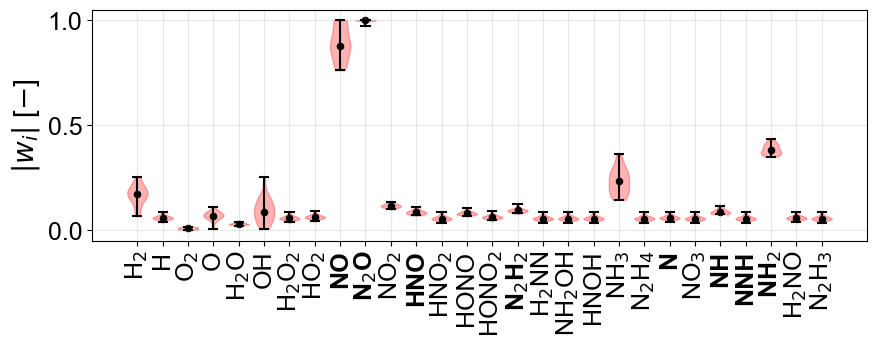

In [13]:
weights_collected = populate_weights_matrix(model_weights_filename_5perc, random_seeds_list)

plot_violins(weights_collected, '../paper/supplementary-figures/supplement-violin-plot-weights-05perc-' + pure_streams_prefix + '.pdf')

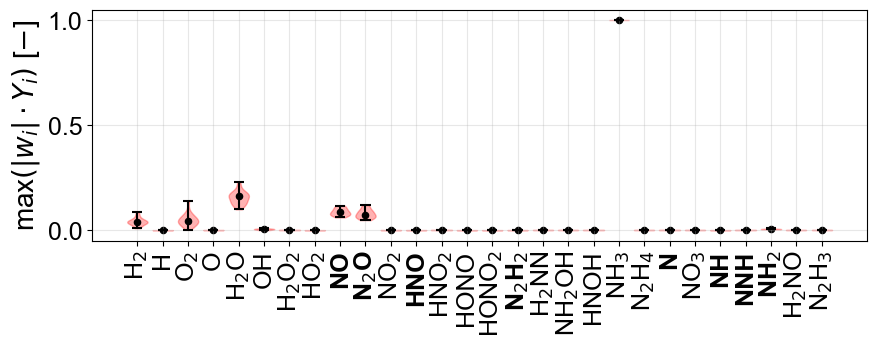

In [14]:
max_collected = populate_max_matrix(model_weights_filename_5perc, random_seeds_list)

plot_max_violins(max_collected, '../paper/supplementary-figures/supplement-violin-plot-max-05perc-' + pure_streams_prefix + '.pdf')

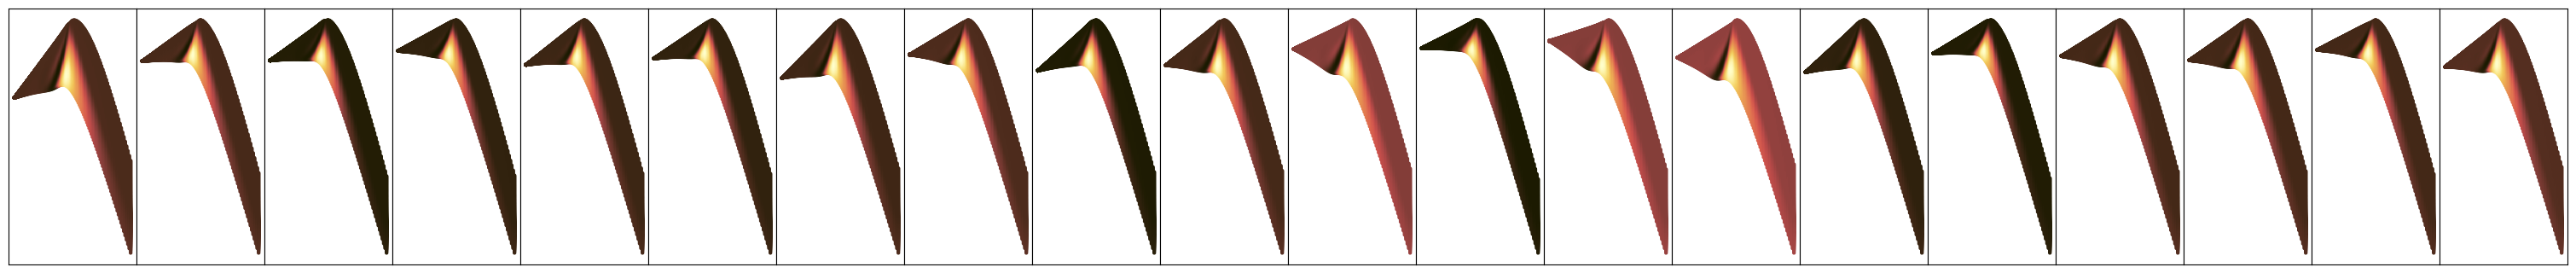

In [15]:
plot_manifolds(model_weights_filename_5perc, random_seeds_list, '../paper/supplementary-figures/supplement-f-PV-05perc-' + pure_streams_prefix + '.png')

<a id=10perc></a>
***

## Violin plot for 10% dilution

[**Go to the top ↑**](#top-page)

In [16]:
random_seeds_list = [i for i in range(0,20)]

In [17]:
data_tag = 'NH3-H2-air-10perc'
%run -i ../scripts/ammonia-Stagni-load-data.py
tex_names = tex_names[1::]


Using: T, H2, O2, H2O, OH, NO as target state variables at the decoder output.

23690 observations
29 state variables


<Figure size 640x480 with 0 Axes>

In [18]:
model_weights_filename_10perc = '../results-paper/f-PV-' + pure_streams_prefix + '-SLF-NH3-H2-air-10perc-target-T-H2-O2-H2O-OH-NO-RandomNormal-e-500000-CD-300000-lr-0.01-alr-0.001-scale-none-darch-0-10-10-rho-0.9-mom-0.5-momcent-no-best-model-weights-rs-'

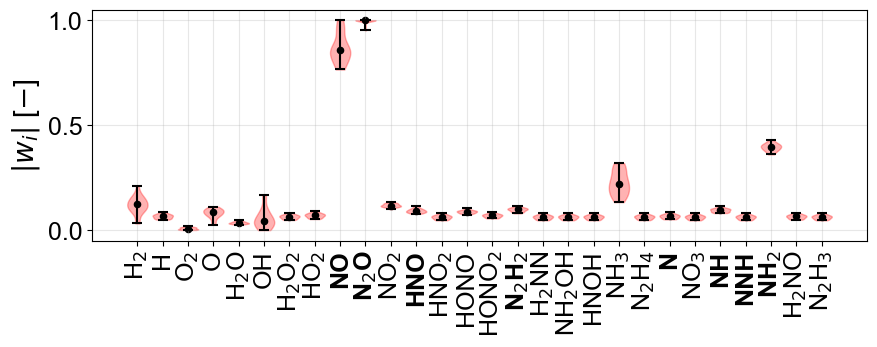

In [19]:
weights_collected = populate_weights_matrix(model_weights_filename_10perc, random_seeds_list)

plot_violins(weights_collected, '../paper/supplementary-figures/supplement-violin-plot-weights-10perc-' + pure_streams_prefix + '.pdf')

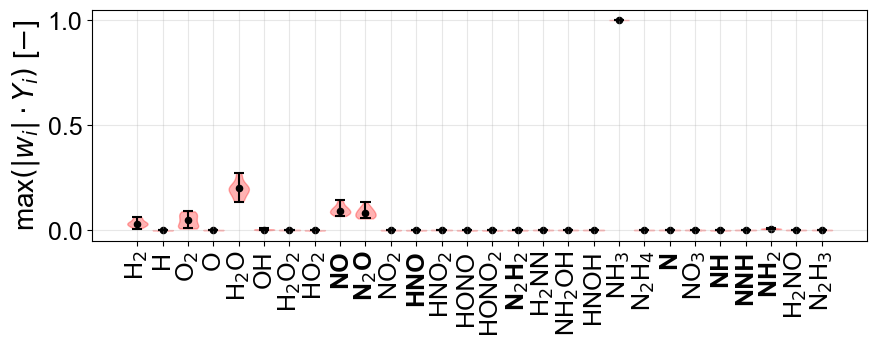

In [20]:
max_collected = populate_max_matrix(model_weights_filename_10perc, random_seeds_list)

plot_max_violins(max_collected, '../paper/supplementary-figures/supplement-violin-plot-max-10perc-' + pure_streams_prefix + '.pdf')

In [ ]:
plot_manifolds(model_weights_filename_10perc, random_seeds_list, '../paper/supplementary-figures/supplement-f-PV-10perc-' + pure_streams_prefix + '.png')

<a id=25perc></a>
***

## Violin plot for 25% dilution

[**Go to the top ↑**](#top-page)

In [ ]:
random_seeds_list = [i for i in range(0,20)]

In [ ]:
data_tag = 'NH3-H2-air-25perc'
%run -i ../scripts/ammonia-Stagni-load-data.py
tex_names = tex_names[1::]

In [ ]:
model_weights_filename_25perc = '../results-paper/f-PV-' + pure_streams_prefix + '-SLF-NH3-H2-air-25perc-target-T-H2-O2-H2O-OH-NO-RandomNormal-e-500000-CD-300000-lr-0.01-alr-0.001-scale-none-darch-0-10-10-rho-0.9-mom-0.5-momcent-no-best-model-weights-rs-'

In [ ]:
weights_collected = populate_weights_matrix(model_weights_filename_25perc, random_seeds_list)

plot_violins(weights_collected, '../paper/violin-plot-weights-' + pure_streams_prefix + '.pdf')

In [ ]:
max_collected = populate_max_matrix(model_weights_filename_25perc, random_seeds_list)

plot_max_violins(max_collected, '../paper/violin-plot-max-' + pure_streams_prefix + '.pdf')

In [ ]:
plot_manifolds(model_weights_filename_25perc, random_seeds_list, '../paper/supplementary-figures/supplement-f-PV-25perc-' + pure_streams_prefix + '.png')

<a id=40perc></a>
***

## Violin plot for 40% dilution

[**Go to the top ↑**](#top-page)

In [ ]:
random_seeds_list = [i for i in range(0,20)]

In [ ]:
data_tag = 'NH3-H2-air-40perc'
%run -i ../scripts/ammonia-Stagni-load-data.py
tex_names = tex_names[1::]

In [ ]:
model_weights_filename_40perc = '../results-paper/f-PV-' + pure_streams_prefix + '-SLF-NH3-H2-air-40perc-target-T-H2-O2-H2O-OH-NO-RandomNormal-e-500000-CD-300000-lr-0.01-alr-0.001-scale-none-darch-0-10-10-rho-0.9-mom-0.5-momcent-no-best-model-weights-rs-'

In [ ]:
weights_collected = populate_weights_matrix(model_weights_filename_40perc, random_seeds_list)

plot_violins(weights_collected, '../paper/supplementary-figures/supplement-violin-plot-weights-40perc-' + pure_streams_prefix + '.pdf')

In [ ]:
max_collected = populate_max_matrix(model_weights_filename_40perc, random_seeds_list)

plot_max_violins(max_collected, '../paper/supplementary-figures/supplement-violin-plot-max-40perc-' + pure_streams_prefix + '.pdf')

In [ ]:
plot_manifolds(model_weights_filename_40perc, random_seeds_list, '../paper/supplementary-figures/supplement-f-PV-40perc-' + pure_streams_prefix + '.png')

***

© K. Zdybał, J. C. Sutherland, A. Parente, Combustion and Flame (2024)